<a href="https://colab.research.google.com/github/CodeHunterOfficial/Data-Mining/blob/main/01.LinearModels/Lecture_1_1_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Регуляризация

__Сложность модели__ (*model complexity*) — важный гиперпараметр. В частности, для линейных моделей сложность может быть представлена количеством параметров, например, для полиномиальных моделей — степенью полинома.

Сложность модели тесно связана с __ошибкой обобщения__ (_generalization error_). Ошибка обобщения отличается от ошибки обучения, измеряемой на тренировочных данных, тем, что позволяет оценить обобщающую способность модели, приобретенную в процессе обучения, давать точные ответы на неизвестных ей объектах. Cлишком простой модели не будет хватать количества параметров для обобщения сложной закономерности в данных, что приведёт к большой ошибке обобщения. С другой стороны, избыточная сложность модель также приводит к большой ошибке обобщения за счет того, что в силу своей сложности модель начинает пытаться искать закономерности в шуме, добиваясь большей точности на тренировочных данных, теряя при этом часть обобщающей способности.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L02/out/model_complexity.png" width="500">

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L02/out/l2_regularization.png" width="300">

Параметры модели задают некоторую **аппроксимацию целевой функции**. Аппроксимировать целевую функцию можно несколькими способами, например:
1. Использовать все имеющиеся данные и провести ее строго **через все точки**, которые нам известны ($f1$ на картинке);
2. Использовать более простую функцию (в данном случае, линейную), которая не попадет точно во все данные, но зато будет соответствовать некоторым **общим закономерностям**, которые у них есть ($f2$ на картинке).

Характерной чертой переобучения является первый сценарий, и сопровождается он, как правило, **большими весами**.

Проиллюстрируем описанное явление на примере полиномиальной модели:

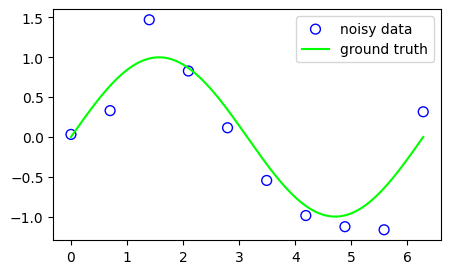

In [ ]:
x = np.linspace(0, 2 * np.pi, 10)
y = np.sin(x) + np.random.normal(scale=0.25, size=len(x))
x_true = np.linspace(0, 2 * np.pi, 200)
y_true = np.sin(x_true)

plt.figure(figsize=(5, 3))
plt.scatter(x, y, s=50, facecolors="none", edgecolors="b", label="noisy data")
plt.plot(x_true, y_true, c="lime", label="ground truth")
plt.legend()
plt.show()

Попробуем аппроксимировать имеющуюся зависимость с помощью полиномиальной модели, используя шумные данные в качестве тренировочных данных:

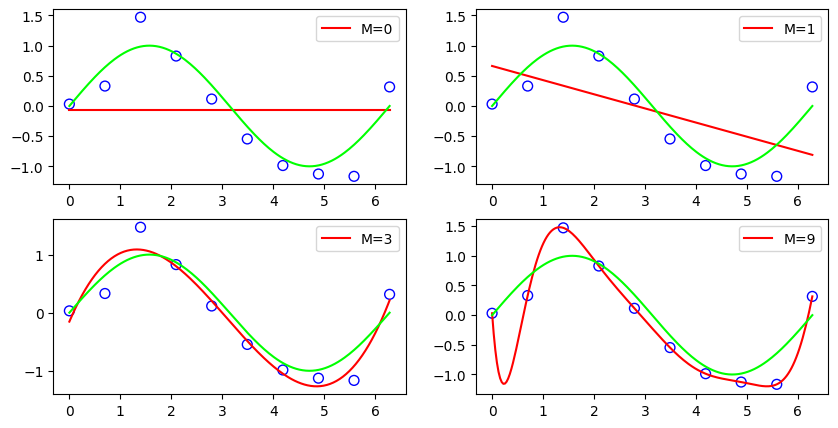

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

x_train = x.reshape(-1, 1)

fig = plt.figure(figsize=(10, 5))

for i, degree in enumerate([0, 1, 3, 9]):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    model.fit(x_train, y)
    y_plot = model.predict(x_true.reshape(-1, 1))

    fig.add_subplot(2, 2, i + 1)
    plt.plot(x_true, y_plot, c="red", label=f"M={degree}")
    plt.scatter(x, y, s=50, facecolors="none", edgecolors="b")
    plt.plot(x_true, y_true, c="lime")
    plt.legend()
plt.show()

Видно, что модель может переобучаться, подстраиваясь под тренировочную выборку. В полиноме степень, и, как следствие, количество весов — это гиперпараметр, который можно подбирать на кросс-валидации, однако когда мы таким образом подбираем сложность модели, мы накладываем довольно грубое ограничение на обобщающую способность модели в целом. Вместо этого более разумным было бы оставить модель сложной, но использовать некий ограничитель (__регуляризатор__), который будет заставлять модель отдавать предпочтение выбору более простого обобщения.

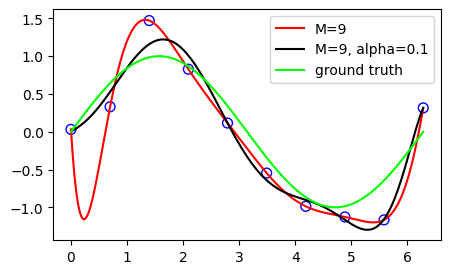

Without regularization:  y = 0.0+-12.11*x+39.41*x^2+-46.31*x^3+28.6*x^4+-10.48*x^5+2.35*x^6+-0.32*x^7+0.02*x^8+-0.0*x^9
With regularization:  y = 0.0+0.37*x+0.52*x^2+0.23*x^3+-0.19*x^4+-0.21*x^5+0.17*x^6+-0.04*x^7+0.01*x^8+-0.0*x^9


In [ ]:
from sklearn.linear_model import Ridge

model = make_pipeline(PolynomialFeatures(9), LinearRegression())
model_ridge = make_pipeline(PolynomialFeatures(9), Ridge(alpha=0.1))

model.fit(x_train, y)
y_plot = model.predict(x_true.reshape(-1, 1))

model_ridge.fit(x_train, y)
y_plot_ridge = model_ridge.predict(x_true.reshape(-1, 1))

plt.figure(figsize=(5, 3))
plt.plot(x_true, y_plot, c="red", label=f"M={degree}")
plt.plot(x_true, y_plot_ridge, c="black", label=f"M={degree}, alpha=0.1")
plt.scatter(x, y, s=50, facecolors="none", edgecolors="b")
plt.plot(x_true, y_true, c="lime", label="ground truth")
plt.legend()
plt.show()

poly_coef = model[1].coef_

eq = f"y = {round(poly_coef[0], 2)}+{round(poly_coef[1], 2)}*x"
for i in range(2, 10):
    eq += f"+{round(poly_coef[i], 2)}*x^{i}"

print("Without regularization: ", eq)

poly_coef = model_ridge[1].coef_

eq = f"y = {round(poly_coef[0], 2)}+{round(poly_coef[1], 2)}*x"
for i in range(2, 10):
    eq += f"+{round(poly_coef[i], 2)}*x^{i}"

print("With regularization: ", eq)

Видно, что одним из "симптомов" переобучения являются аномально большие веса.
https://aunnnn.github.io/ml-tutorial/html/blog_content/linear_regression/linear_regression_regularized.html

Как регуляризация может исправить вашу регрессию
Давайте продемонстрируем эффект регуляризации на примере и увидим, что чем больше регуляризации мы добавляем (фактор α
), тем меньше веса w
становиться.


Для простоты мы не будем использовать какие-либо конкретные пакеты ML, вместо этого мы обучаем простую модель линейной регрессии в векторной форме:

In [4]:
import numpy as np

# Определяем матрицу признаков X размером 6x3 с почти одинаковыми вторым и третьим столбцами
X = np.array([[4, 4, 4],
              [3, 5, 5],
              [5, 1, 1],
              [5, 4, 4],
              [7, 5, 5],
              [4, 5, 5.00000001]])

# Определяем вектор y размером 1x6
y = np.array([1, 2, 3, 1, 2, 3])

# Вычисляем матрицу Грама для X
XTX = X.T.dot(X)
print(XTX)

# Находим обратную матрицу для матрицы Грама
XTX_inv = np.linalg.inv(XTX)
print(XTX_inv)

# Вычисляем вектор весов w:
w = XTX_inv.dot(X.T).dot(y)
print(w)

[[140.         111.         111.00000004]
 [111.         108.         108.00000005]
 [111.00000004 108.00000005 108.0000001 ]]


LinAlgError: Singular matrix

Эта ошибка возникает, когда матрица является сингулярной, то есть ее определитель равен нулю. В таком случае обратная матрица не существует или вычисления невозможны. Необходимо проверить данные или применить соответствующие методы для работы с сингулярными матрицами.

Как видно, второе и третье значения вектора весов w огромны. Это происходит из-за того, что исходная матрица признаков X содержит почти одинаковые столбцы: 2 и 3.

Давайте введем регуляризацию и посмотрим, как изменится вектор w.

In [5]:
# Добавляем регуляризационный коэффициент 0.01 к главной диагонали матрицы Грама
XTX = XTX + 0.01 * np.eye(3)
print(XTX)

# Находим обратную матрицу для матрицы Грама
XTX_inv = np.linalg.inv(XTX)
print(XTX_inv)

# Вычисляем вектор весов w:
w = XTX_inv.dot(X.T).dot(y)
print(w)

[[140.01       111.         111.00000004]
 [111.         108.01       108.00000005]
 [111.00000004 108.00000005 108.0100001 ]]
[[ 3.85624712e-02 -1.98159300e-02 -1.98158861e-02]
 [-1.98159300e-02  5.00124975e+01 -4.99875026e+01]
 [-1.98158861e-02 -4.99875026e+01  5.00124974e+01]]
[0.33643484 0.04007035 0.04007161]


"Необходимость регуляризации*

В отличие от аппроксимации полиномом, трудно представить, как линейная регрессия может переобучить данные, поскольку это всего лишь одна линия (или гиперплоскость). Одна из ситуаций заключается в том, что функции коррелируют или избыточны.

Предположим, есть два объекта, оба абсолютно одинаковые. Наша прогнозируемая гиперплоскость будет в этом формате:

$$y = w_0 + w_1*x_1 + w_2*x_2$$

и истинные значения x2 почти то же самое, что x1 (или с некоторым мультипликативным коэффициентом и шумом). Тогда лучше просто исключить термин w2*x2 и использовать:


Модель Ridge Regression, показанная в примере выше, использует L2-регуляризацию для борьбы с этим явлением:

$$L_2 = \alpha \sum_i w_i^2,$$
где $\alpha$ — это коэффициент регуляризации.


 Введение **L2-регуляризации** приводит к тому, что **большие веса больше штрафуются** и предпочтение отдается решениям, использующим **малые значения весов**. При этом модель будет **сохранять скоррелированные и неважные признаки с маленькими весами**.

Это связано с градиентом $L_2$:
$$L'_{2w_i} = 2\alpha w_i$$
Он будет “тянуть” модель в сторону маленьких весов.

<center><img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L02/out/l1_and_l2_regularization.gif" alt="alttext" width="550"/></center>

Для отбора признаков можно использовать L1-регуляризацию, она больше штрафует маленькие веса.

$$\large L_1 = \alpha \sum_i |w_i|$$
$$\large L_{1w_i}' = \alpha, \text{  где } w_i\neq 0$$

L1 одинаково "штрафует" модель за любые ненулевые веса.



Для получения интуиции, что L1-регуляризация позволяет отбирать признаки, обычно используют картинку ниже.

Голубая область — ограничение на значения весов, которое дает регуляризация.
Для **L2** это **окружность**. Черная точка — это минимальное значение для функции Loss с регуляризацией. Для **L2** она будет лежать **на касательной к окружности**. Для **L1** ограничения на значения весов будут иметь **форму ромба**. При этом минимальное значение для функции Loss с регуляризацией будет чаще попадать в **угол ромба**, что соответствует **обнулению веса** одного из признаков.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L02/out/l1_l2_regularization.png" width="1000">

# Литература
* https://link.springer.com/chapter/10.1007/978-3-030-95860-2_3

* https://datatalks.club/blog/regularization-in-regression.html

* https://github.com/alexeygrigorev/mlbookcamp-code/tree/master
